In [1]:
import pyleoclim as pyleo #this is the paleoclimate python model -- May not use this 
import xarray as xr #xarray is the processing package that helps deal with large datasets (often gridded data)
import pandas as pd #this is the main python package that deals with open source data analysis and manipulation


import sys #this is a module that provides various functions and variables
import numpy as np

from netCDF4 import num2date


from statsmodels.tsa.seasonal import seasonal_decompose

import cftime #this is a time related pacakge

# this is all for plotting...
import matplotlib as mpl #mapping and plotting package
import matplotlib.pyplot as plt
%matplotlib inline

import cartopy #this is another mapping package
# from cartopy.util import add_cyclic_point
# from cartopy.mpl.geoaxes import GeoAxes
# from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import AxesGrid
# from matplotlib.colors import BoundaryNorm
# import matplotlib.colors as colors
# from matplotlib.colors import LinearSegmentedColormap
# import cartopy.feature as cfeature
# import matplotlib.mlab as mlab

import datetime
from datetime import date, datetime, timedelta   # to convert "days since XXX" to date
# import xarray as xr
# import datetime as dt2         # to create a datetime object


#this is all for the stats 

from scipy.signal import find_peaks
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress
import statsmodels.api as sm

from pylr2 import regress2 

In [2]:
# filepath = ('C:\\Users\\jhargreaves\\Documents\\Science\\Mauritius\\Jess_working')
# filepath = ('/Users/jessicahargreaves/Documents_2/Germany/Mauritius_Coral_Science/Mauritius/Jess_working/')
MAU2_SrCa = pd.read_excel('MAU2_shorted_for_prac.xlsx') #https://www.apcc21.org/ser/indic.do?lang=en#grap2 
MAU2_SrCa

,Probe,Unnamed: 1,Intervall [cm],depth,Unnamed: 4,sample,SrCa_outliers,SrCa
0,Mau-2/,1,NaN,0.000,A,1,9.603866,NaN
1,Mau-2/,2,0.175,0.175,A,2,9.323335,9.323335
2,Mau-2/,3,0.150,0.325,A,3,9.164798,9.164798
3,Mau-2/,4,0.150,0.475,A,4,9.061630,9.061630
4,Mau-2/,5,0.150,0.625,A,5,9.010160,9.010160
...,...,...,...,...,...,...,...,...
221,Mau-2/,222,0.125,35.050,H,222,9.224453,9.224453
222,Mau-2/,223,0.125,35.175,H,223,9.045796,9.045796
223,Mau-2/,224,0.150,35.325,H,224,8.977354,8.977354
224,Mau-2/,225,0.150,35.475,H,225,9.034190,9.034190


In [3]:
MAU2_SrCa_xr = xr.Dataset({'corr_SrCa':MAU2_SrCa.SrCa},
                   # coords={'mm':(('mm'),MAU1_SrCa.mm)},
                     attrs=dict(description="MAU1_SrCa_Corrected_SrCa"),)
# coords={'mm':MAU1_SrCa.mm},
# MAU1_SrCa_xr['mm']=MAU1_SrCa.mm
MAU2_SrCa_xr['depth']=MAU2_SrCa.depth


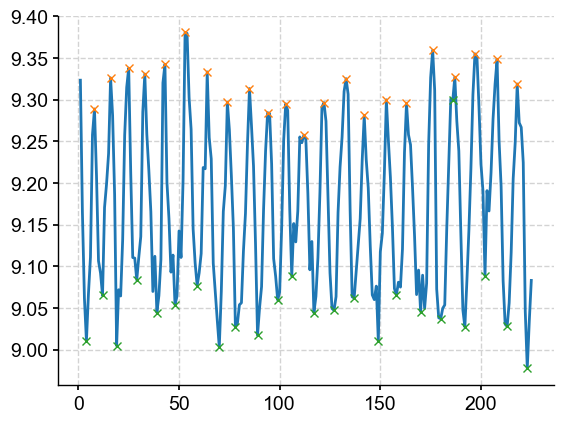

In [4]:
# import plotly.express as px
peaks_high, _ = find_peaks(MAU2_SrCa_xr.corr_SrCa, distance=5, height=9.2)
peaks_low, _ = find_peaks(-MAU2_SrCa_xr.corr_SrCa, distance=6)

plt.plot(MAU2_SrCa_xr.corr_SrCa)
plt.plot(peaks_high, MAU2_SrCa_xr.corr_SrCa[peaks_high], "x")
plt.plot(peaks_low, MAU2_SrCa_xr.corr_SrCa[peaks_low], "x")

plt.show()


In [5]:
df = pd.DataFrame({'depth_markers':MAU2_SrCa_xr.depth[peaks_high]})
df.loc[-1] = [0]
df
df.index = df.index + 1  # shifting index
df.sort_index(inplace=True)
df

,depth_markers
0,0.000
1,1.300
2,2.600
3,4.100
4,5.350
5,6.950
6,8.225
7,10.050
8,11.750
9,13.475


In [6]:
ERSST_short = xr.open_dataset('ERSST_MAU2de.nc') # this is how we open a netcdf4 file into an xarray dataset 
# ERSST_short= ERSST_short.to_array()
ERSST_short

<xarray.Dataset>
Dimensions:  (time: 138)
Coordinates:
  * time     (time) float64 1.967e+03 1.967e+03 1.967e+03 ... 1.99e+03 1.99e+03
Data variables:
    sst      (time) float32 ...

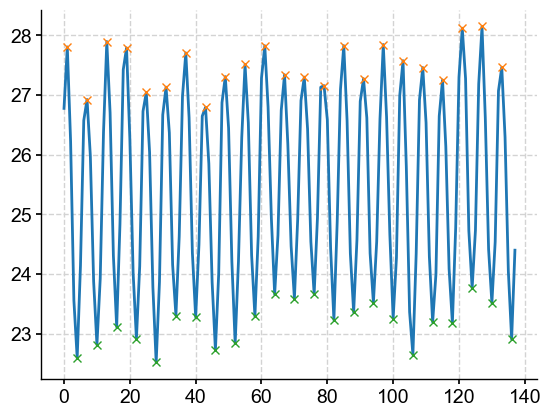

In [7]:
peaks_highERSST_short, _ = find_peaks(ERSST_short.sst, distance=3)
peaks_lowERSST_short, _ = find_peaks(-ERSST_short.sst, distance=3)
plt.plot(ERSST_short.sst)
plt.plot(peaks_highERSST_short, ERSST_short.sst[peaks_highERSST_short], "x")
plt.plot(peaks_lowERSST_short, ERSST_short.sst[peaks_lowERSST_short], "x")
# plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()
high_temp_ERERSST_short= ERSST_short.sst[peaks_highERSST_short]
low_temp_ERERSST_short = ERSST_short.sst[peaks_lowERSST_short]

In [8]:
Date_markers = ERSST_short.sst[peaks_lowERSST_short]
Date_markers


Date_markers = Date_markers.reindex(time=list(reversed(Date_markers.time)))
Date_markers

<xarray.DataArray 'sst' (time: 23)>
array([22.903894, 23.511616, 23.760345, 23.176525, 23.190426, 22.643353,
       23.249966, 23.51586 , 23.35643 , 23.2269  , 23.659096, 23.58695 ,
       23.656586, 23.287647, 22.832863, 22.719835, 23.273624, 23.300447,
       22.514334, 22.911118, 23.109379, 22.810677, 22.58738 ], dtype=float32)
Coordinates:
  * time     (time) float64 1.99e+03 1.989e+03 1.988e+03 ... 1.969e+03 1.968e+03

In [9]:
df['date_markers'] = Date_markers.time
df

,depth_markers,date_markers
0,0.000,1989.75
1,1.300,1988.75
2,2.600,1987.75
3,4.100,1986.75
4,5.350,1985.75
5,6.950,1984.75
6,8.225,1983.75
7,10.050,1982.75
8,11.750,1981.75
9,13.475,1980.75


In [10]:
import matplotlib.pyplot as plt
from scipy import interpolate

In [11]:
# Datenew = np.linspace(1879-3/12, 1990-5/12, 666) #creating the depth age -- original date time
Datenew_Mau2 = np.linspace(1968-9/12, 1990-3/12, 136) #creating the depth age -- original date time

%store Datenew_Mau2
Datenew_Mau2

Stored 'Datenew_Mau2' (ndarray)


array([1967.25      , 1967.41666667, 1967.58333333, 1967.75      ,
       1967.91666667, 1968.08333333, 1968.25      , 1968.41666667,
       1968.58333333, 1968.75      , 1968.91666667, 1969.08333333,
       1969.25      , 1969.41666667, 1969.58333333, 1969.75      ,
       1969.91666667, 1970.08333333, 1970.25      , 1970.41666667,
       1970.58333333, 1970.75      , 1970.91666667, 1971.08333333,
       1971.25      , 1971.41666667, 1971.58333333, 1971.75      ,
       1971.91666667, 1972.08333333, 1972.25      , 1972.41666667,
       1972.58333333, 1972.75      , 1972.91666667, 1973.08333333,
       1973.25      , 1973.41666667, 1973.58333333, 1973.75      ,
       1973.91666667, 1974.08333333, 1974.25      , 1974.41666667,
       1974.58333333, 1974.75      , 1974.91666667, 1975.08333333,
       1975.25      , 1975.41666667, 1975.58333333, 1975.75      ,
       1975.91666667, 1976.08333333, 1976.25      , 1976.41666667,
       1976.58333333, 1976.75      , 1976.91666667, 1977.08333

In [12]:
#interpolates the age to the linear portion of the data, this creates a date for each data point. 
# SE18_Int.year = interp1(Markers.Full_extra_depthMinimum, Markers.Full_extra_datesMinimum, SE18_cons.depth_cons_Top,'linear','extrap');
f = interpolate.interp1d(df.depth_markers,df.date_markers,fill_value="extrapolate")(MAU2_SrCa.depth) 


In [13]:
# SE18_Int.monthly_d180 = interp1(SE18_Int.year, SE18_cons.d18O_cons_Top, Markers.year_month,'linear','extrap');
monthlySr_MAU2 = interpolate.interp1d(f,MAU2_SrCa.SrCa)(Datenew_Mau2) ## this interpolates the data onto a new depth section
# monthlyMg_MAU2 = interpolate.interp1d(f,MAU2_SrCa.MgCa_remo)(Datenew_Mau2) ## this interpolates the data onto a new depth section

%store monthlySr_MAU2

Stored 'monthlySr_MAU2' (ndarray)


(1960.0, 1999.0)

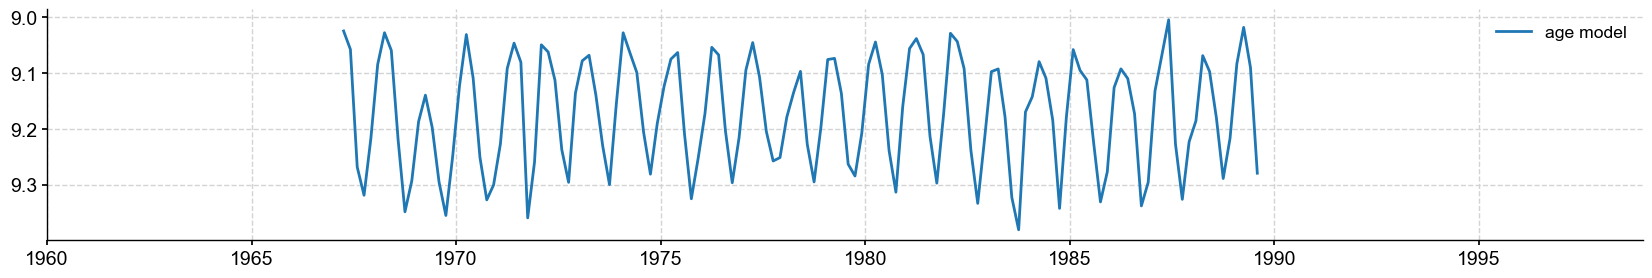

In [14]:
# plotting the data together to look at what is happening
fig = plt.figure(figsize=(70, 3))


ax = fig.add_subplot(1, 3, 1)
# ax.plot( f,MAU1_SrCa.corr_SrCaoutliers_nan, '-', label = 'full age')
ax.plot(Datenew_Mau2,monthlySr_MAU2,'-', label = 'age model')
# ax.plot(Datenew,monthlySr_full,'-', label = 'age model full')
plt.gca().invert_yaxis()




# ax2.set_ylabel('SST', color= 'blue') 
# ax2.tick_params(axis='y', color='blue', labelcolor='blue')
ax.legend()
# ax2.set_ylim([21.5,29])
ax.set_xlim([1960,1999])


